In [1]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv("Desktop/datasets/Rock_Pop/fma-rock-vs-hiphop.csv")

# Read in track metrics with the features
echonest_metrics = pd.read_json("Desktop/datasets/Rock_Pop/echonest-metrics.json",precise_float = True)

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['track_id','genre_top']],on = ["track_id"])

# Inspect the resultant dataframe
echo_tracks.info()
echo_tracks.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
track_id            4802 non-null int64
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
valence             4802 non-null float64
genre_top           4802 non-null object
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,341,0.977282,0.468808,0.134975,0.687700,0.105381,0.073124,119.646,0.430707,Rock
3,46204,0.953349,0.498525,0.552503,0.924391,0.684914,0.028885,78.958,0.430448,Rock
4,46205,0.613229,0.500320,0.487992,0.936811,0.637750,0.030327,112.667,0.824749,Rock


In [2]:
# Create a correlation matrix to check wheater to drop redendunt feature or no
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1,-0.372282,0.0494541,0.140703,-0.275623,0.0482307,-0.0269951,-0.0253918,0.0100698
acousticness,-0.372282,1,-0.0289537,-0.281619,0.19478,-0.0199914,0.072204,-0.0263097,-0.0138406
danceability,0.0494541,-0.0289537,1,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1,0.0282377,0.113331,-0.109983,0.195227,0.0386027
instrumentalness,-0.275623,0.19478,-0.255217,0.0282377,1,-0.0910218,-0.366762,0.022215,-0.219967
liveness,0.0482307,-0.0199914,-0.106584,0.113331,-0.0910218,1,0.0411725,0.00273169,-0.0450931
speechiness,-0.0269951,0.072204,0.276206,-0.109983,-0.366762,0.0411725,1,0.00824055,0.149894
tempo,-0.0253918,-0.0263097,-0.242089,0.195227,0.022215,0.00273169,0.00824055,1,0.0522212
valence,0.0100698,-0.0138406,0.473165,0.0386027,-0.219967,-0.0450931,0.149894,0.0522212,1


In [3]:
#Drop unrelevant features
features = echo_tracks.drop(['genre_top','track_id'],axis = 1)

# Define our labels
labels = echo_tracks.loc[:,'genre_top']

from sklearn.preprocessing import StandardScaler

# Scale the features to fit for PCA
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

array([0.24297674, 0.18044316, 0.13650309, 0.12994089, 0.11056248,
       0.08302245, 0.06923783, 0.04731336])

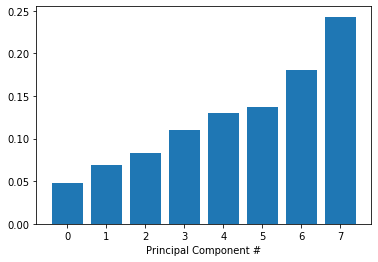

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(x = np.arange(7,-1,-1),height =exp_variance)
ax.set_xlabel('Principal Component #')
exp_variance


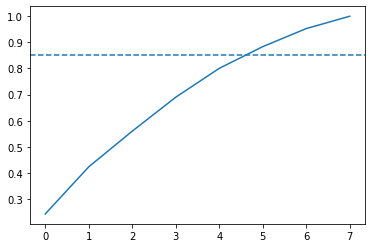

In [5]:
# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')
plt.show()


# choose the n_components where about 85% of our variance can be explained
n_components = np.sum(cum_exp_variance < 0.85)

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)


In [6]:
# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,labels,random_state = 10)

# Train our decision tree
tree = DecisionTreeClassifier(random_state = 10)
tree.fit(train_features,train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

In [7]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_features,train_labels)
pred_labels_logit = logreg.predict(test_features)

# Create the classification report for both models
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

class_rep_tree = classification_report(test_labels,pred_labels_tree)
class_rep_log = classification_report(test_labels,pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)
print("Decision Tree accuarcy : " , accuracy_score(test_labels,pred_labels_tree))
print("Logistic Regression accuarcy : " , accuracy_score(test_labels,pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.64      0.62       229
        Rock       0.91      0.90      0.91       972

    accuracy                           0.85      1201
   macro avg       0.76      0.77      0.76      1201
weighted avg       0.85      0.85      0.85      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.73      0.57      0.64       229
        Rock       0.90      0.95      0.93       972

    accuracy                           0.88      1201
   macro avg       0.82      0.76      0.78      1201
weighted avg       0.87      0.88      0.87      1201

Decision Tree accuarcy :  0.8501248959200666
Logistic Regression accuarcy :  0.8784346378018318


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [8]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks['genre_top']== 'Hip-Hop',:] 
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock',:]

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(len(hop_only),random_state=10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only,hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection,labels, random_state=10)

In [9]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features,train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features,train_labels)
pred_labels_logit = logreg.predict(test_features)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels,pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels,pred_labels_logit))
print("Decision Tree accuarcy : " , accuracy_score(test_labels,pred_labels_tree))
print("Logistic Regression accuarcy : " , accuracy_score(test_labels,pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.79      0.81      0.80       230
        Rock       0.80      0.78      0.79       225

    accuracy                           0.79       455
   macro avg       0.79      0.79      0.79       455
weighted avg       0.79      0.79      0.79       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.81      0.83      0.82       230
        Rock       0.82      0.80      0.81       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455

Decision Tree accuarcy :  0.7934065934065934
Logistic Regression accuarcy :  0.8153846153846154


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [16]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold cross-validation
kf = KFold(n_splits=10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# Train our models using KFold cv
tree_score = cross_val_score(tree,pca_projection,labels,cv=kf)
logit_score = cross_val_score(logreg,pca_projection,labels,cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7340659340659341 Logistic Regression: 0.7763736263736263


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

In [10]:
#Trying to find state of the art model
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(train_features, train_labels)
y_pred_rf = rnd_clf.predict(test_features)


print("Random Forset: \n", classification_report(test_labels,y_pred_rf))
print("Random Forest accuarcy : " , accuracy_score(test_labels,y_pred_rf))


Random Forset: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.84      0.84       230
        Rock       0.84      0.84      0.84       225

    accuracy                           0.84       455
   macro avg       0.84      0.84      0.84       455
weighted avg       0.84      0.84      0.84       455

Random Forest accuarcy :  0.8395604395604396


In [11]:
#Try XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

gbm = xgb.XGBClassifier()
gbm_param_grid = {
    'colsample_bytree': [0.3,0.5, 0.7],
    'n_estimators': [50],
    'max_depth': [2, 5,8]
}

# Perform grid search
grid = GridSearchCV(param_grid=gbm_param_grid,estimator = gbm,cv = 4,verbose = 1)


#fitting data to grid_search and making predictions

grid.fit(train_features,train_labels)
y_pred_gs = grid.predict(test_features)

print("XBGoost GridSearch : \n", classification_report(test_labels,y_pred_gs))

print("XGBoost classification error : ",accuracy_score(test_labels,y_pred_gs) )

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    3.6s finished


XBGoost GridSearch : 
               precision    recall  f1-score   support

     Hip-Hop       0.86      0.82      0.84       230
        Rock       0.83      0.87      0.85       225

    accuracy                           0.84       455
   macro avg       0.84      0.84      0.84       455
weighted avg       0.84      0.84      0.84       455

XGBoost classification error :  0.843956043956044
